In [1]:
pip install xgboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 6.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 2.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 14.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [58]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score, cohen_kappa_score, davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRegressor
# from catboost import CatBoostClassifier

import optuna 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/TS-S3-Ep5/train.csv'
file_key_2 = 'Tabular-Playground-Series/TS-S3-Ep5/test.csv'
file_key_3 = 'Tabular-Playground-Series/TS-S3-Ep5/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

## Enginering features
# train['total_acid'] = train['fixed acidity'] + train['volatile acidity'] + train['citric acid']
# train['acid/density'] = train['total_acid']  / train['density']
train['alcohol_density'] = train['alcohol'] * train['density']
train['sulphate/density'] = train['sulphates']  / train['density']
# train['sulphates/acid'] = train['sulphates'] / train['volatile acidity']
# train['sulphates/chlorides'] = train['sulphates'] / train['chlorides']
# train['sulphates*alcohol'] = train['sulphates'] / train['alcohol']
train['alcohol_sulphate'] = train['alcohol'] * train['sulphates']
train['pH_round'] = train['pH'].round(1)
# train['pH_round'] = np.where(train['pH_round'] <= 3.0, 3.0,
#                              np.where(train['pH_round'] >= 3.7, 3.7, train['pH_round']))

# train['citric_acid_per_alcohol'] = np.where(train['alcohol'] == 0, 0, train['citric acid'] / train['alcohol'])

alcohol_mean_groupby_pH = pd.DataFrame(train.groupby('pH_round')['alcohol'].mean())
alcohol_mean_groupby_pH.columns = ['mean_alcohol_by_pH_round']
alcohol_mean_groupby_pH['pH_round'] = alcohol_mean_groupby_pH.index
alcohol_mean_groupby_pH = alcohol_mean_groupby_pH.reset_index(drop = True)

sulphates_mean_groupby_pH = pd.DataFrame(train.groupby('pH_round')['sulphates'].mean())
sulphates_mean_groupby_pH.columns = ['mean_sulphates_by_pH_round']
sulphates_mean_groupby_pH['pH_round'] = sulphates_mean_groupby_pH.index
sulphates_mean_groupby_pH = sulphates_mean_groupby_pH.reset_index(drop = True)

train = pd.merge(train, alcohol_mean_groupby_pH, on = 'pH_round', how = 'left')
train = pd.merge(train, sulphates_mean_groupby_pH, on = 'pH_round', how = 'left')


test['alcohol_density'] = test['alcohol']  * test['density']
test['sulphate/density'] = test['sulphates']  / test['density']
test['alcohol_sulphate'] = test['alcohol'] * test['sulphates']

test['pH_round'] = test['pH'].round(1)
# test['pH_round'] = np.where(test['pH_round'] <= 3.0, 3.0,
#                              np.where(test['pH_round'] >= 3.7, 3.7, test['pH_round']))

alcohol_mean_groupby_pH = pd.DataFrame(test.groupby('pH_round')['alcohol'].mean())
alcohol_mean_groupby_pH.columns = ['mean_alcohol_by_pH_round']
alcohol_mean_groupby_pH['pH_round'] = alcohol_mean_groupby_pH.index
alcohol_mean_groupby_pH = alcohol_mean_groupby_pH.reset_index(drop = True)

sulphates_mean_groupby_pH = pd.DataFrame(test.groupby('pH_round')['sulphates'].mean())
sulphates_mean_groupby_pH.columns = ['mean_sulphates_by_pH_round']
sulphates_mean_groupby_pH['pH_round'] = sulphates_mean_groupby_pH.index
sulphates_mean_groupby_pH = sulphates_mean_groupby_pH.reset_index(drop = True)

test = pd.merge(test, alcohol_mean_groupby_pH, on = 'pH_round', how = 'left')
test = pd.merge(test, sulphates_mean_groupby_pH, on = 'pH_round', how = 'left')

test_md = test.copy()

# X = train[['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates', 'mean_alcohol_by_pH_round', 'mean_sulphates_by_pH_round']]
X = train[['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates']]
Y = train['quality'] 

# test_md = test_md[['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates', 'mean_alcohol_by_pH_round', 'mean_sulphates_by_pH_round']]
test_md = test_md[['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates']]

In [59]:
X.head()

,sulphate/density,alcohol_density,alcohol,sulphates
0,0.773310,12.048212,12.1,0.77
1,0.670980,12.781312,12.8,0.67
2,0.732490,11.261580,11.3,0.73
3,0.531435,9.773540,9.8,0.53
4,1.367604,9.447180,9.5,1.36


In [7]:
test_md.head()

,sulphate/density,alcohol_density,alcohol,sulphates,mean_alcohol_by_pH_round,mean_sulphates_by_pH_round
0,0.591491,9.775304,9.8,0.59,10.599601,0.645505
1,0.682827,9.958600,10.0,0.68,10.404323,0.655418
2,0.651472,9.478530,9.5,0.65,10.309804,0.630000
3,0.653398,11.639160,11.7,0.65,10.404323,0.655418
4,0.483111,12.717568,12.8,0.48,10.447824,0.665159


In [113]:
train['pH_round'].value_counts()

3.3    544
3.4    486
3.2    462
3.5    216
3.1    179
3.6     90
3.0     55
3.7     24
Name: pH_round, dtype: int64

In [76]:
Y[train['pH_round'] == 3.8]

339     8
369     6
696     5
708     5
1265    5
1992    6
Name: quality, dtype: int64

In [68]:
Y[train['pH_round'] == 2.9]

238     7
1155    6
1401    6
1429    6
1747    6
Name: quality, dtype: int64

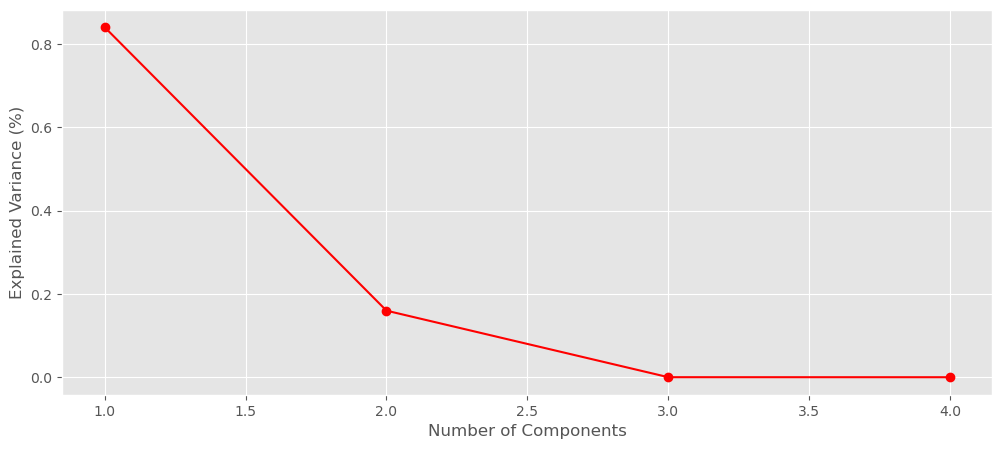

In [60]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
pca = PCA()
X_0_1 = pd.DataFrame(scaler.fit_transform(X), columns = X.columns) 
pca.fit(X_0_1)
explained_variance = pca.explained_variance_ratio_
num_components = np.arange(len(explained_variance)) + 1

# Plot the elbow graph
# x = [1, 2, 3, 4]
plt.figure(figsize = (12, 5))
plt.plot(num_components, explained_variance, 'ro-')
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance (%)")
plt.show()

In [9]:
np.cumsum(explained_variance)

array([0.74902264, 0.89268702, 0.95746947, 0.99994382, 0.9999999 ,
       1.        ])

Text(0, 0.5, 'Third Component')

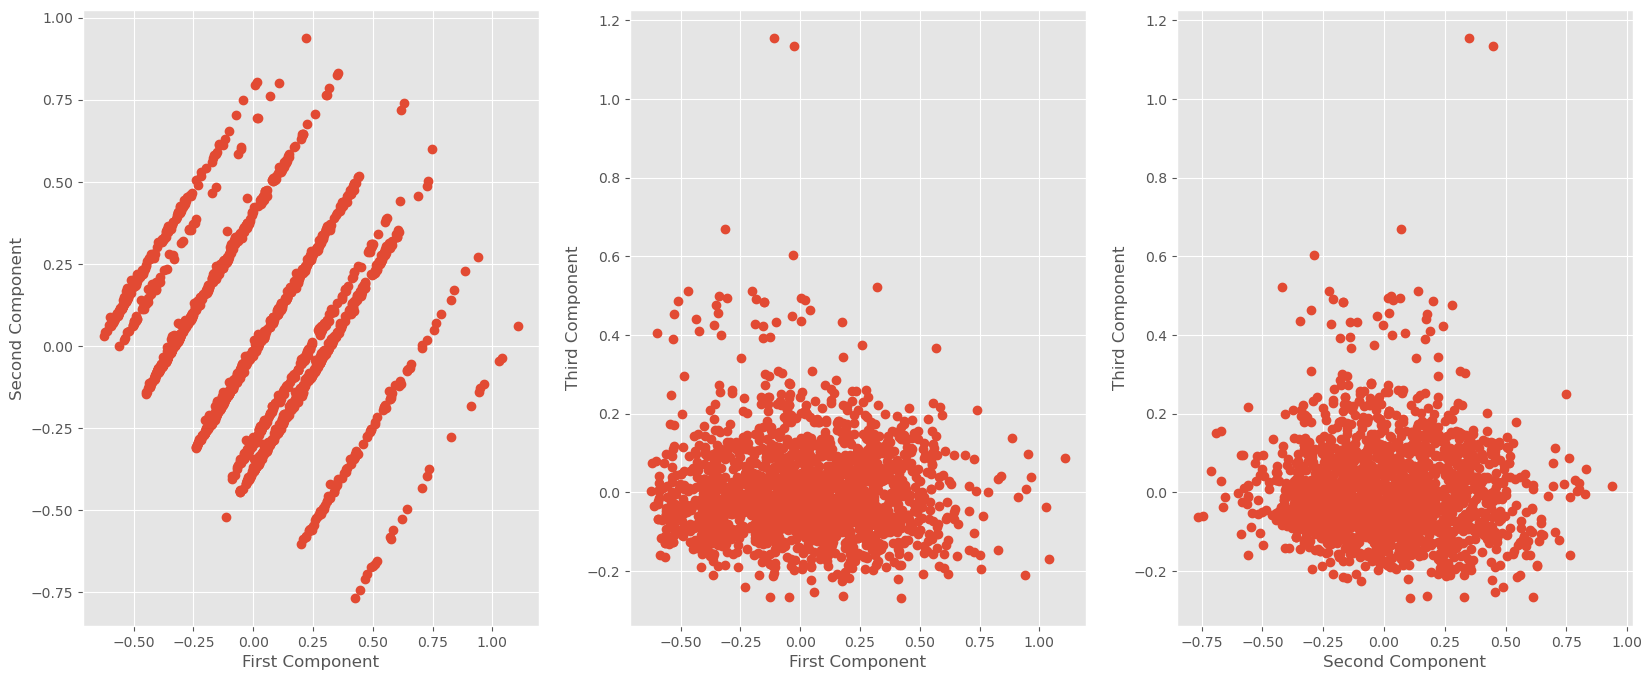

In [121]:
# fig, axs = plt.subplots(1, 3, figsize = (20, 8))

# X_pca = PCA(n_components = 3).fit_transform(X_0_1)
# X_pca = pd.DataFrame(X_pca, columns = ['First_Component', 'Second_Component', 'Third_Component'])

# axs[0].plot(X_pca['First_Component'], X_pca['Second_Component'], 'o')
# axs[0].set_xlabel('First Component')
# axs[0].set_ylabel('Second Component')

# axs[1].plot(X_pca['First_Component'], X_pca['Third_Component'], 'o')
# axs[1].set_xlabel('First Component')
# axs[1].set_ylabel('Third Component')

# axs[2].plot(X_pca['Second_Component'], X_pca['Third_Component'], 'o')
# axs[2].set_xlabel('Second Component')
# axs[2].set_ylabel('Third Component')

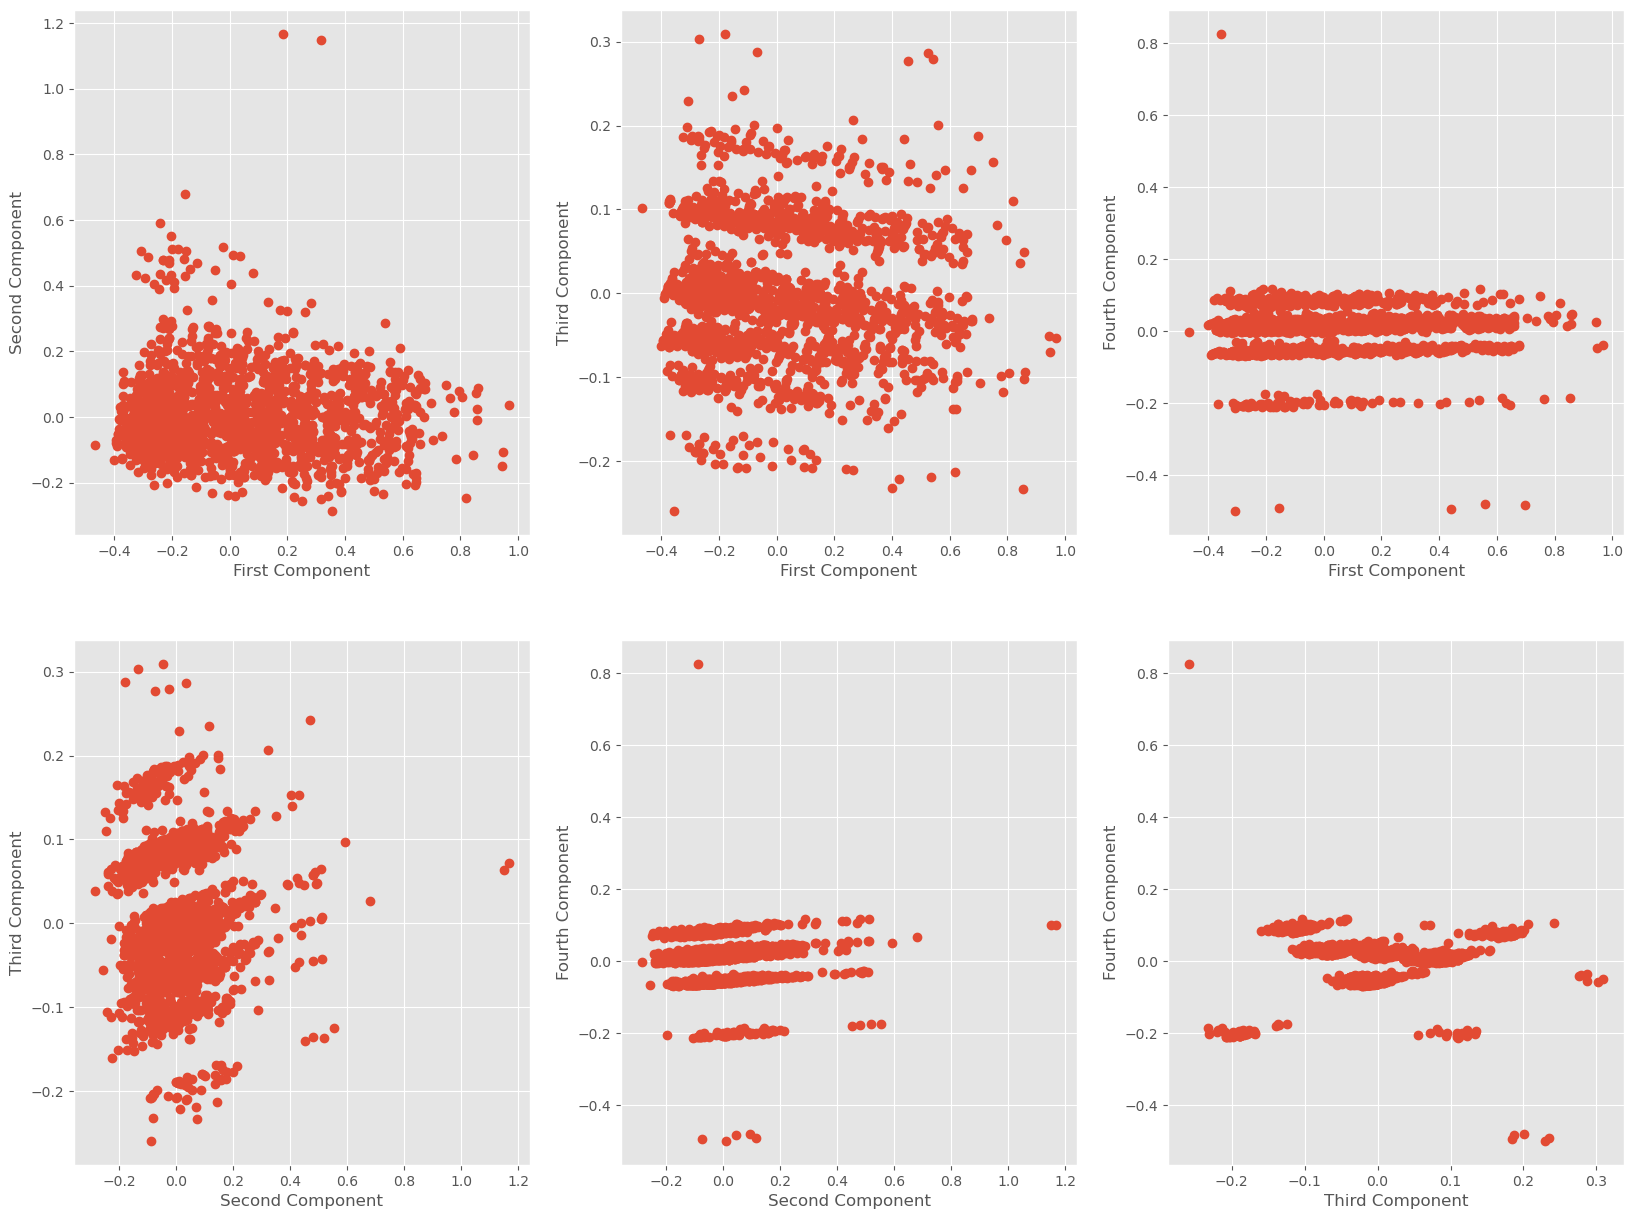

In [10]:
fig, axs = plt.subplots(2, 3, figsize = (20, 15))

pca = PCA(n_components = 4).fit(X_0_1)
X_pca = pca.transform(X_0_1)
X_pca = pd.DataFrame(X_pca, columns = ['First_Component', 'Second_Component', 'Third_Component', 'Fourth_Component'])

axs[0, 0].plot(X_pca['First_Component'], X_pca['Second_Component'], 'o')
axs[0, 0].set_xlabel('First Component')
axs[0, 0].set_ylabel('Second Component')

axs[0, 1].plot(X_pca['First_Component'], X_pca['Third_Component'], 'o')
axs[0, 1].set_xlabel('First Component')
axs[0, 1].set_ylabel('Third Component')

axs[0, 2].plot(X_pca['First_Component'], X_pca['Fourth_Component'], 'o')
axs[0, 2].set_xlabel('First Component')
axs[0, 2].set_ylabel('Fourth Component')
               
axs[1, 0].plot(X_pca['Second_Component'], X_pca['Third_Component'], 'o')
axs[1, 0].set_xlabel('Second Component')
axs[1, 0].set_ylabel('Third Component')

axs[1, 1].plot(X_pca['Second_Component'], X_pca['Fourth_Component'], 'o')
axs[1, 1].set_xlabel('Second Component')
axs[1, 1].set_ylabel('Fourth Component')

axs[1, 2].plot(X_pca['Third_Component'], X_pca['Fourth_Component'], 'o')
axs[1, 2].set_xlabel('Third Component')
axs[1, 2].set_ylabel('Fourth Component');               

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


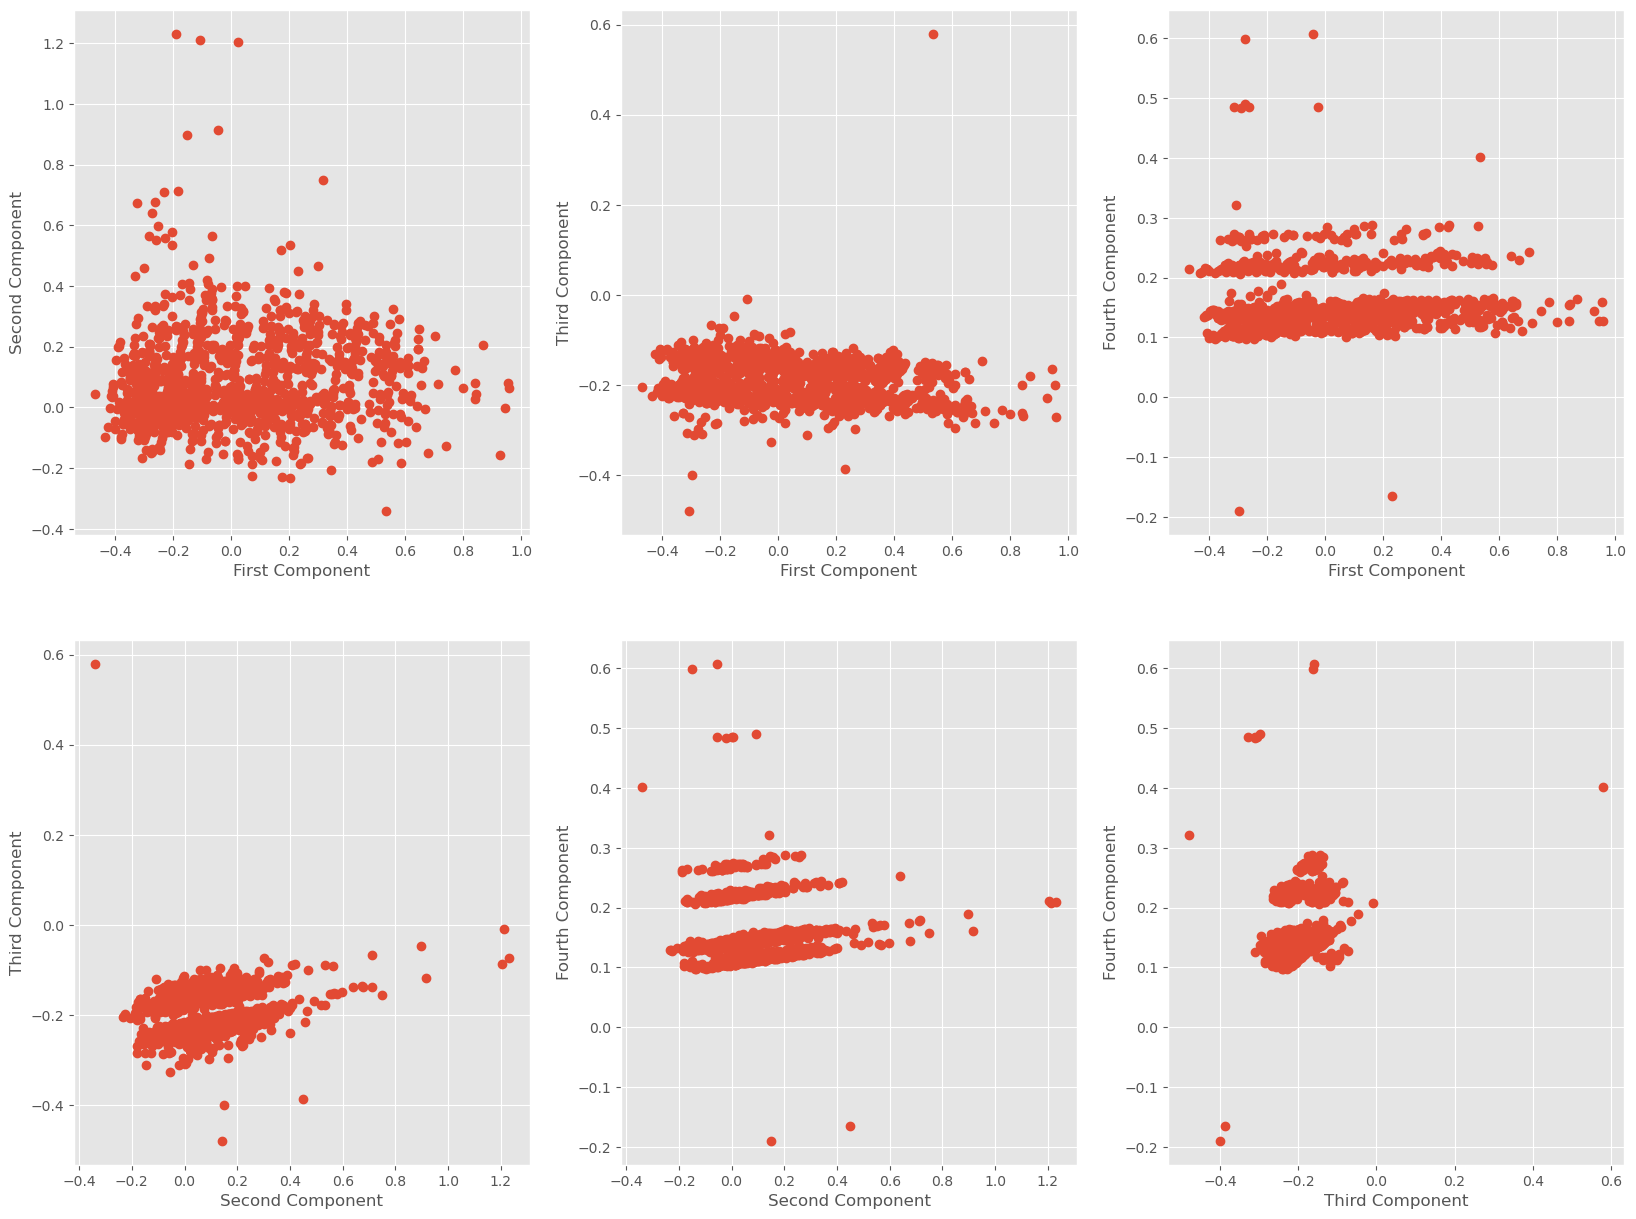

In [11]:
fig, axs = plt.subplots(2, 3, figsize = (20, 15))

test_0_1 = scaler.fit_transform(test_md)
test_pca = pca.transform(test_0_1)
test_pca = pd.DataFrame(test_pca, columns = ['First_Component', 'Second_Component', 'Third_Component', 'Fourth_Component'])

axs[0, 0].plot(test_pca['First_Component'], test_pca['Second_Component'], 'o')
axs[0, 0].set_xlabel('First Component')
axs[0, 0].set_ylabel('Second Component')

axs[0, 1].plot(test_pca['First_Component'], test_pca['Third_Component'], 'o')
axs[0, 1].set_xlabel('First Component')
axs[0, 1].set_ylabel('Third Component')

axs[0, 2].plot(test_pca['First_Component'], test_pca['Fourth_Component'], 'o')
axs[0, 2].set_xlabel('First Component')
axs[0, 2].set_ylabel('Fourth Component')
               
axs[1, 0].plot(test_pca['Second_Component'], test_pca['Third_Component'], 'o')
axs[1, 0].set_xlabel('Second Component')
axs[1, 0].set_ylabel('Third Component')

axs[1, 1].plot(test_pca['Second_Component'], test_pca['Fourth_Component'], 'o')
axs[1, 1].set_xlabel('Second Component')
axs[1, 1].set_ylabel('Fourth Component')

axs[1, 2].plot(test_pca['Third_Component'], test_pca['Fourth_Component'], 'o')
axs[1, 2].set_xlabel('Third Component')
axs[1, 2].set_ylabel('Fourth Component');               

In [260]:
X = pd.concat([X, X_pca], axis = 1)
X.head()

,sulphate/density,alcohol_density,alcohol,sulphates,pH_round,mean_alcohol_by_pH_round,First_Component,Second_Component,Third_Component,Fourth_Component
0,0.773310,12.048212,12.1,0.77,3.3,10.440993,0.456904,0.060046,0.042823,0.011248
1,0.670980,12.781312,12.8,0.67,3.3,10.440993,0.632886,0.052706,-0.075251,0.009752
2,0.732490,11.261580,11.3,0.73,3.5,10.417824,0.256867,-0.112774,0.071394,-0.081921
3,0.531435,9.773540,9.8,0.53,3.2,10.270202,-0.186912,0.089371,-0.098155,-0.010616
4,1.367604,9.447180,9.5,1.36,3.2,10.270202,-0.165860,0.247453,0.643430,-0.015783


In [261]:
test_md = pd.concat([test_md, test_pca], axis = 1)
test_md.head()

,sulphate/density,alcohol_density,alcohol,sulphates,pH_round,mean_alcohol_by_pH_round,First_Component,Second_Component,Third_Component,Fourth_Component
0,0.591491,9.775304,9.8,0.59,3.4,10.599601,-0.194444,0.101271,0.005277,-0.172155
1,0.682827,9.958600,10.0,0.68,3.3,10.404323,-0.138573,0.222200,0.077676,-0.192756
2,0.651472,9.478530,9.5,0.65,3.1,10.309804,-0.288391,0.352095,0.033769,-0.145057
3,0.653398,11.639160,11.7,0.65,3.3,10.404323,0.308801,0.244731,-0.026226,-0.197852
4,0.483111,12.717568,12.8,0.48,3.2,10.447824,0.568025,0.281336,-0.272876,-0.150998


In [57]:
X['pH_round'].value_counts()

3.3    544
3.4    486
3.2    462
3.5    216
3.1    179
3.6     90
3.0     49
3.7     18
3.8      6
2.9      5
2.7      1
Name: pH_round, dtype: int64

In [72]:
test['pH_round'].value_counts()

3.4    376
3.3    347
3.2    314
3.5    122
3.1    102
3.6     53
3.0     32
3.7     15
2.9      5
3.8      2
3.9      2
4.0      1
2.7      1
Name: pH_round, dtype: int64

In [55]:
X[X['Second_Component'] > 0.4]

,sulphate/density,alcohol_density,alcohol,sulphates,pH_round,mean_alcohol_by_pH_round,First_Component,Second_Component,Third_Component,Fourth_Component
1270,0.509898,9.20184,9.2,0.51,2.7,9.2,-0.409504,0.706142,-0.226521,-0.256019


In [73]:
X[X['Second_Component'] < -0.4]

,sulphate/density,alcohol_density,alcohol,sulphates,pH_round,mean_alcohol_by_pH_round,First_Component,Second_Component,Third_Component,Fourth_Component
311,0.481734,9.266520,9.3,0.48,3.7,10.794444,-0.274989,-0.437618,-0.013918,0.002904
339,0.795633,12.212916,12.3,0.79,3.8,11.016667,0.559583,-0.452616,0.163417,0.044313
369,0.664693,12.014574,12.1,0.66,3.8,11.016667,0.490967,-0.481704,0.057528,0.045899
696,0.490785,9.384960,9.4,0.49,3.8,11.016667,-0.231681,-0.561873,0.017195,0.055503
708,0.472899,10.137474,10.2,0.47,3.8,11.016667,-0.029731,-0.552096,-0.031438,0.053215
1145,0.534506,9.717386,9.8,0.53,3.7,10.794444,-0.143468,-0.419279,0.011386,0.001038
1265,0.602289,9.663140,9.7,0.60,3.8,11.016667,-0.141840,-0.535106,0.102122,0.053782
1774,0.623768,9.442620,9.5,0.62,3.7,10.794444,-0.207978,-0.406672,0.101653,0.001276
1794,0.562305,9.759820,9.8,0.56,3.7,10.794444,-0.134320,-0.413200,0.035791,0.000758
1992,0.735628,12.305140,12.4,0.73,3.8,11.016667,0.577428,-0.462728,0.106966,0.044455


In [71]:
X[X['Third_Component'] > 0.6]

,sulphate/density,alcohol_density,alcohol,sulphates,pH_round,mean_alcohol_by_pH_round,First_Component,Second_Component,Third_Component,Fourth_Component
4,1.367604,9.44718,9.5,1.36,3.2,10.270202,-0.165860,0.247453,0.643430,-0.015783
132,1.956260,10.46640,10.5,1.95,3.2,10.270202,0.172994,0.380783,1.117190,-0.023290
547,1.954691,10.97360,11.0,1.95,3.2,10.270202,0.305417,0.389417,1.095707,-0.024860
1208,1.264679,9.16596,9.2,1.26,3.5,10.417824,-0.229232,-0.045076,0.622554,-0.079277


In [59]:
X[X['Fourth_Component'] > 0.5]

,sulphate/density,alcohol_density,alcohol,sulphates,pH_round,mean_alcohol_by_pH_round,First_Component,Second_Component,Third_Component,Fourth_Component
238,0.789684,12.90516,12.9,0.79,2.9,11.24,0.670620,0.211187,-0.000065,0.525512
1155,0.602531,9.16136,9.2,0.60,2.9,11.24,-0.332206,0.109226,-0.011292,0.538548
1401,0.618053,12.03780,12.0,0.62,2.9,11.24,0.416846,0.162268,-0.112968,0.529536
1429,0.740444,9.69418,9.7,0.74,2.9,11.24,-0.179074,0.145541,0.088922,0.535907
1747,0.825448,12.31816,12.4,0.82,2.9,11.24,0.531729,0.208093,0.051131,0.526972


In [70]:
X[X['Fourth_Component'] < -0.1]

,sulphate/density,alcohol_density,alcohol,sulphates,pH_round,mean_alcohol_by_pH_round,First_Component,Second_Component,Third_Component,Fourth_Component
1270,0.509898,9.20184,9.2,0.51,2.7,9.2,-0.409504,0.706142,-0.226521,-0.256019


In [128]:
X_pca = PCA(n_components = 3).fit_transform(X_0_1)
# X_pca_trans = scaler.fit_transform(X_pca)
X_pca = pd.DataFrame(X_pca, columns = ['First_Component', 'Second_Component', 'Third_Component'])
cluster_md = KMeans(n_clusters = 6, n_init = 100).fit(X_pca[['First_Component', 'Second_Component']])
cluster_md.labels_

array([4, 4, 0, ..., 4, 5, 3], dtype=int32)

In [129]:
# X_pca = pd.DataFrame(scaler.fit_transform(X_pca), columns = ['First_Component', 'Second_Component', 'Third_Component', 'Fourth_Component'])
X_pca['cluster'] = cluster_md.labels_
X_pca.head()

,First_Component,Second_Component,Third_Component,cluster
0,0.301811,0.347852,0.051383,4
1,0.418137,0.479560,-0.067292,4
2,0.296418,0.068591,0.045265,0
3,-0.308159,0.026873,-0.087586,5
4,-0.315148,0.069928,0.669122,5


In [130]:
X_pca['cluster'].value_counts()

2    612
5    463
0    412
4    239
1    227
3    103
Name: cluster, dtype: int64

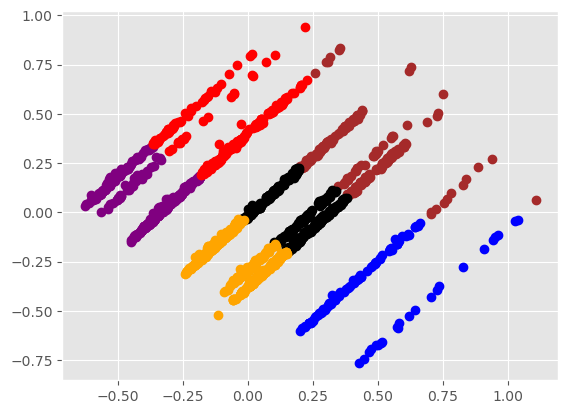

In [132]:
colors = ['black', 'red', 'orange', 'blue', 'brown', 'purple']

for i in X_pca['cluster'].unique():
    
    data_temp = X_pca[X_pca['cluster'] == i]
    plt.plot('First_Component', 'Second_Component', 'o', data = data_temp, color = colors[i])


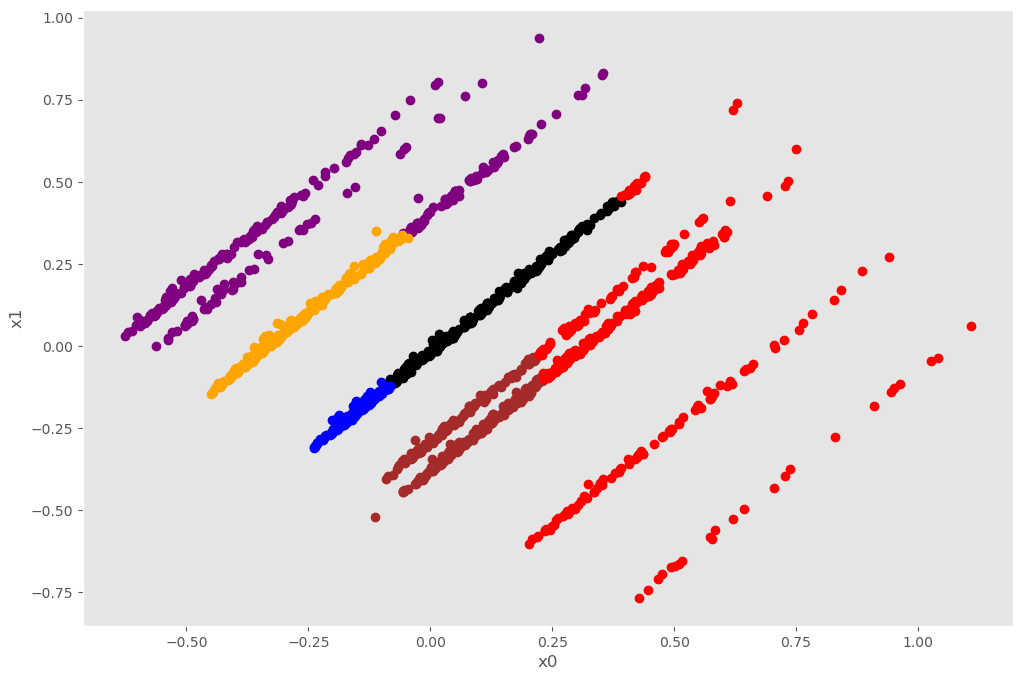

In [135]:
from sklearn.cluster import SpectralClustering

## Fitting spectral clustering with 2 clusters
spectral_clustering = SpectralClustering(n_clusters = 6, 
                                         affinity = 'nearest_neighbors',
                                         n_neighbors = 15).fit(X_pca[['First_Component', 'Second_Component']])

## Appending cluster to the sine dataset
X_pca['spectral_clusters'] = spectral_clustering.labels_

## Visualizing the data with cluster
colors = ['black', 'red', 'orange', 'blue', 'brown', 'purple']

plt.figure(figsize = (12, 8))
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()

for i in X_pca['cluster'].unique():
        
    data_temp = X_pca[X_pca['spectral_clusters'] == i]
    plt.plot('First_Component', 'Second_Component', 'o', data = data_temp, color = colors[i])

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


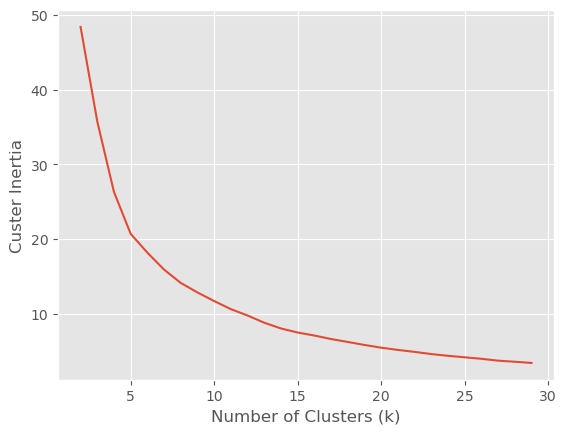

In [21]:
scaler = MinMaxScaler()

X_pca_trans = scaler.fit_transform(X_pca)

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

## Defining the number of clusters to be considered
krange = list(range(2, 30))

## Defining lists to store scores
CH_scores, DB_scores, silhouette_scores = list(), list(), list()
inertias = list()

for i in krange:
    print(i)
    ## Here we define the k-means model
    cluster_md = KMeans(n_clusters = i, n_init = 20).fit(X_pca_trans)
    cluster_assignments = cluster_md.labels_
    inertias.append(cluster_md.inertia_)
    
    ## Here we extract CH, DB and silhoutte scores
    CH = calinski_harabasz_score(X_pca_trans, cluster_assignments)
    DB = davies_bouldin_score(X_pca_trans, cluster_assignments)
    silhouette = silhouette_score(X_pca_trans, cluster_assignments)
    
    ## Storing scores
    CH_scores.append(CH)
    DB_scores.append(DB)
    silhouette_scores.append(silhouette)

plt.plot(krange, inertias)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Custer Inertia')
plt.show()

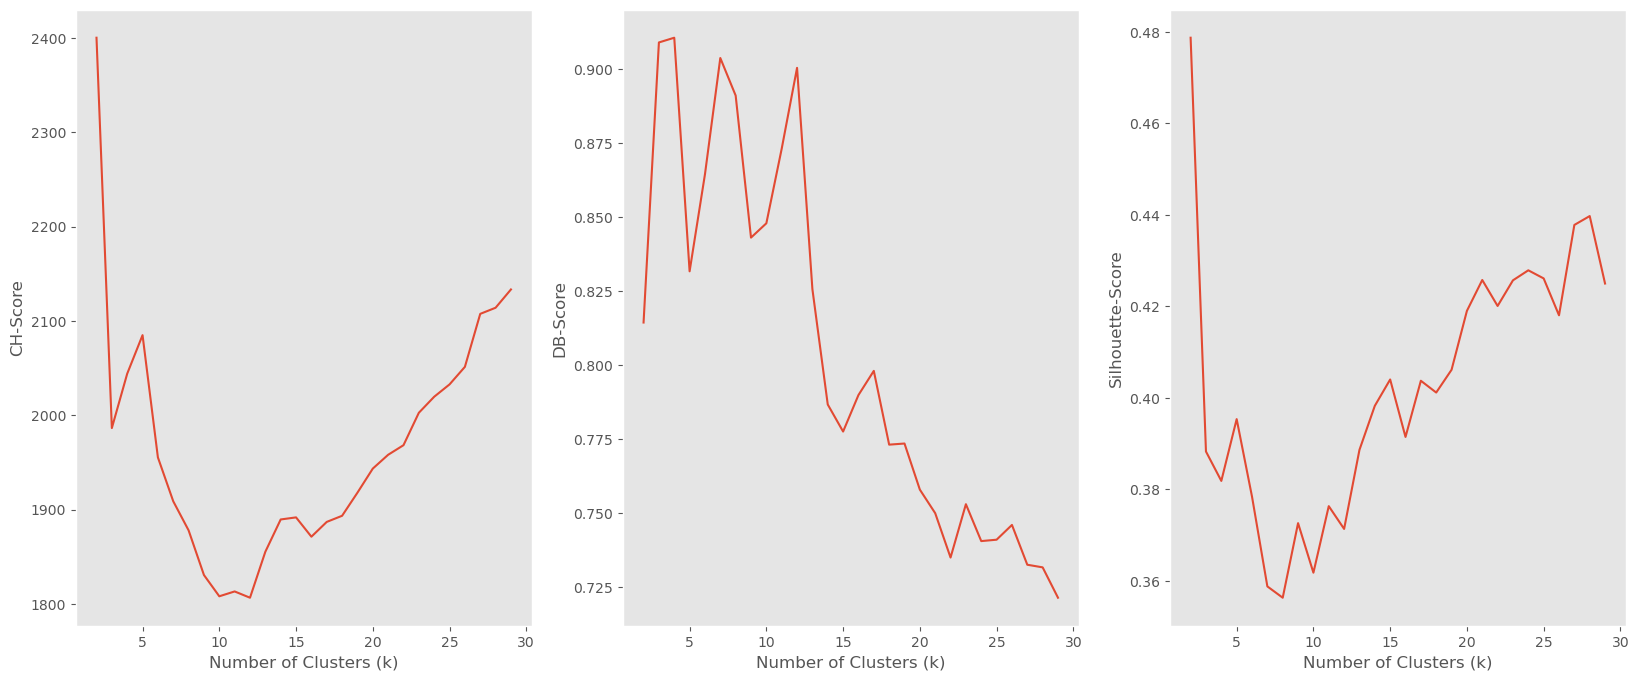

In [22]:
fig, axs = plt.subplots(1, 3, figsize = (20, 8))
axs[0].plot(krange, CH_scores)
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('CH-Score')
axs[0].grid()

axs[1].plot(krange, DB_scores)
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('DB-Score')
axs[1].grid()

axs[2].plot(krange, silhouette_scores)
axs[2].set_xlabel('Number of Clusters (k)')
axs[2].set_ylabel('Silhouette-Score')
axs[2].grid()

In [9]:
np.cumsum(explained_variance)

array([0.67053084, 0.8595038 , 0.98337626, 0.99995106, 0.99999991,
       1.        ])

In [128]:
train['pH_round'].value_counts()

3.3    544
3.4    486
3.2    462
3.5    216
3.1    179
3.6     90
3.0     49
3.7     18
3.8      6
2.9      5
2.7      1
Name: pH_round, dtype: int64

In [129]:
test['pH_round'].value_counts()

3.4    376
3.3    347
3.2    314
3.5    122
3.1    102
3.6     53
3.0     32
3.7     15
2.9      5
3.8      2
3.9      2
4.0      1
2.7      1
Name: pH_round, dtype: int64

In [121]:
train.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,total_acid,acid/density,alcohol_density,sulphate/density,sulphates/acid,sulphates/chlorides,sulphates*alcohol,alcohol_sulphate,pH_round,citric_acid_per_alcohol,mean_alcohol_by_pH_round
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6,8.89,8.928213,12.048212,0.773310,1.540000,10.547945,0.063636,9.317,3.3,0.032231,10.440993
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6,10.33,10.345104,12.781312,0.670980,2.233333,7.282609,0.052344,8.576,3.3,0.057031,10.440993
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7,7.64,7.666065,11.261580,0.732490,1.431373,12.372881,0.064602,8.249,3.5,0.002655,10.417824
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5,9.19,9.214880,9.773540,0.531435,0.609195,6.309524,0.054082,5.194,3.2,0.022449,10.270202
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6,9.16,9.211214,9.447180,1.367604,3.777778,17.215190,0.143158,12.920,3.2,0.031579,10.270202


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


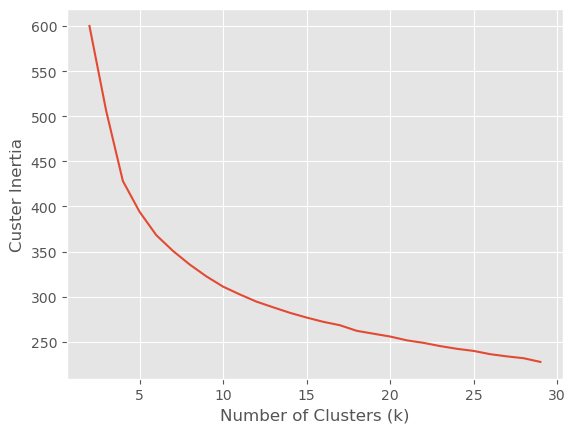

In [122]:
scaler = MinMaxScaler()

# X = train[['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates', 'pH_round']]
X = train.drop(columns = ['Id', 'quality'], axis = 1)
X_trans = scaler.fit_transform(X)

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

## Defining the number of clusters to be considered
krange = list(range(2, 30))

## Defining lists to store scores
CH_scores, DB_scores, silhouette_scores = list(), list(), list()
inertias = list()

for i in krange:
    print(i)
    ## Here we define the k-means model
    cluster_md = KMeans(n_clusters = i, n_init = 20).fit(X_trans)
    cluster_assignments = cluster_md.labels_
    inertias.append(cluster_md.inertia_)
    
    ## Here we extract CH, DB and silhoutte scores
    CH = calinski_harabasz_score(X_trans, cluster_assignments)
    DB = davies_bouldin_score(X_trans, cluster_assignments)
    silhouette = silhouette_score(X_trans, cluster_assignments)
    
    ## Storing scores
    CH_scores.append(CH)
    DB_scores.append(DB)
    silhouette_scores.append(silhouette)

plt.plot(krange, inertias)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Custer Inertia')
plt.show()

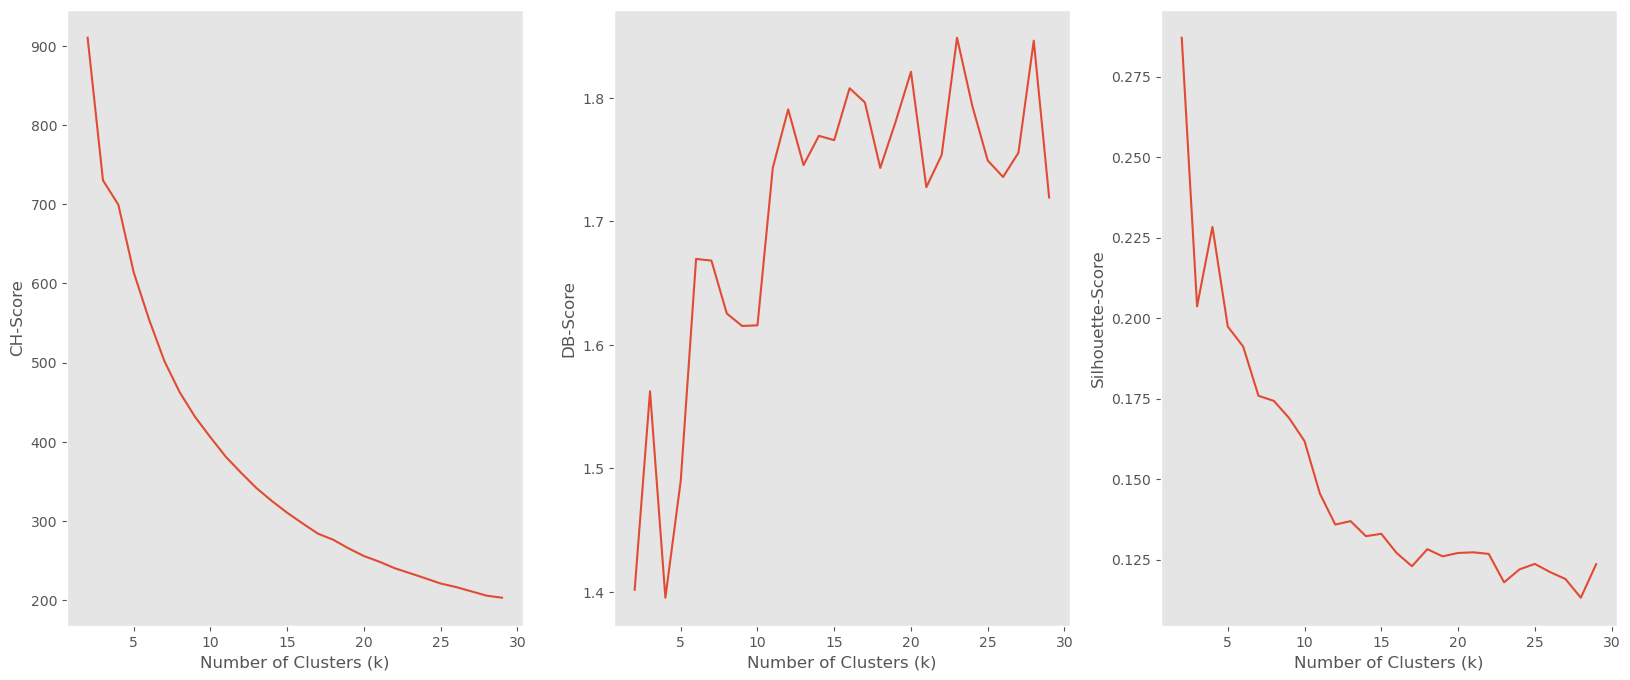

In [123]:
fig, axs = plt.subplots(1, 3, figsize = (20, 8))
axs[0].plot(krange, CH_scores)
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('CH-Score')
axs[0].grid()

axs[1].plot(krange, DB_scores)
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('DB-Score')
axs[1].grid()

axs[2].plot(krange, silhouette_scores)
axs[2].set_xlabel('Number of Clusters (k)')
axs[2].set_ylabel('Silhouette-Score')
axs[2].grid()

# Optimal Rounder

In [61]:
from functools import partial
import numpy as np
import scipy as sp

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 3
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 4
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 5
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 6
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 7
            else:
                X_p[i] = 8

        ll = cohen_kappa_score(y, X_p, weights = 'quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X = X, y = y)
        initial_coef = [3.5, 4.5, 5.5, 6.5, 7.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method = 'nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 3
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 4
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 5
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 6
            elif pred >= coef[3] and pred < coef[4]:
                X_p[i] = 7
            else:
                X_p[i] = 8
        return X_p

    def coefficients(self):
        return self.coef_['x']

# Optuna Optimzation

In [13]:
# X_trans = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
# test_md_trans = pd.DataFrame(scaler.fit_transform(test_md), columns = test_md.columns)

# kmeans_md = KMeans(n_clusters = 5, n_init = 50, random_state = 42).fit(X_trans)

# X['cluster'] = kmeans_md.labels_
# test_md['cluster'] = kmeans_md.predict(test_md_trans)
# X.head()
X.head()

,sulphate/density,alcohol_density,alcohol,sulphates,mean_alcohol_by_pH_round,mean_sulphates_by_pH_round
0,0.773310,12.048212,12.1,0.77,10.440993,0.652610
1,0.670980,12.781312,12.8,0.67,10.440993,0.652610
2,0.732490,11.261580,11.3,0.73,10.417824,0.636481
3,0.531435,9.773540,9.8,0.53,10.270202,0.641385
4,1.367604,9.447180,9.5,1.36,10.270202,0.641385


In [14]:
test_md.head()

,sulphate/density,alcohol_density,alcohol,sulphates,mean_alcohol_by_pH_round,mean_sulphates_by_pH_round
0,0.591491,9.775304,9.8,0.59,10.599601,0.645505
1,0.682827,9.958600,10.0,0.68,10.404323,0.655418
2,0.651472,9.478530,9.5,0.65,10.309804,0.630000
3,0.653398,11.639160,11.7,0.65,10.404323,0.655418
4,0.483111,12.717568,12.8,0.48,10.447824,0.665159


In [62]:
def objective(trial):
    
    ## Parameters to be evaluated
    param = dict(objective = 'reg:absoluteerror',
                 eval_metric = 'mae',
                 tree_method = 'hist', 
                 random_state = 42,
                 max_depth = trial.suggest_int('max_depth', 2, 10),
                 learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1, log = True),
                 n_estimators = trial.suggest_int('n_estimators', 30, 10000),
                 gamma = trial.suggest_float('gamma', 0, 10),
                 min_child_weight = trial.suggest_int('min_child_weight', 1, 100),
                 colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 0.9),
                 subsample = trial.suggest_float('subsample', 0.2, 0.9)
                )

    scores = []

#     skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    skf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, Y)):
        
        print(fold, end = ' ')
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        Y_train , Y_valid = Y.iloc[train_idx] , Y.iloc[valid_idx]

        model = XGBRegressor(**param).fit(X_train, Y_train)

        preds_train = model.predict(X_train)
        preds_valid = model.predict(X_valid)
        
        optR = OptimizedRounder()
        optR.fit(preds_train, Y_train)
        coef = optR.coefficients()
        preds_valid = optR.predict(preds_valid, coef).astype(int)
        
        score = cohen_kappa_score(Y_valid,  preds_valid, weights = 'quadratic')
        scores.append(score)
        
    return np.mean(scores)

In [63]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 50, timeout = 3600)

[I 2023-02-10 13:00:32,725] A new study created in memory with name: no-name-c7bc621d-be8a-4e0b-b0cf-61878329518b


0 1 2 3 4 

[I 2023-02-10 13:01:34,055] Trial 0 finished with value: 0.3786543734078124 and parameters: {'max_depth': 10, 'learning_rate': 0.008416841059172188, 'n_estimators': 8113, 'gamma': 0.13788414641908942, 'min_child_weight': 37, 'colsample_bytree': 0.20720015722017493, 'subsample': 0.2851649529130965}. Best is trial 0 with value: 0.3786543734078124.


0 1 2 3 4 

[I 2023-02-10 13:02:40,593] Trial 1 finished with value: 0.4996287924109183 and parameters: {'max_depth': 2, 'learning_rate': 0.04158021012361853, 'n_estimators': 9579, 'gamma': 6.756706752162116, 'min_child_weight': 52, 'colsample_bytree': 0.6009456725481512, 'subsample': 0.5784820384253979}. Best is trial 1 with value: 0.4996287924109183.


0 1 2 3 4 

[I 2023-02-10 13:03:06,914] Trial 2 finished with value: 0.5133249487760652 and parameters: {'max_depth': 9, 'learning_rate': 0.003343138849027787, 'n_estimators': 830, 'gamma': 4.417746685800078, 'min_child_weight': 93, 'colsample_bytree': 0.6434735420909761, 'subsample': 0.40467180951968795}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:04:08,945] Trial 3 finished with value: 0.47405974137249424 and parameters: {'max_depth': 2, 'learning_rate': 0.019471852280155223, 'n_estimators': 8809, 'gamma': 0.7878561484961899, 'min_child_weight': 28, 'colsample_bytree': 0.5025185249431813, 'subsample': 0.6977813653407885}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:04:52,152] Trial 4 finished with value: 0.48810069977705073 and parameters: {'max_depth': 8, 'learning_rate': 0.0015102705915551607, 'n_estimators': 5412, 'gamma': 1.545872234752823, 'min_child_weight': 79, 'colsample_bytree': 0.32255159403620554, 'subsample': 0.46880880642258954}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:05:28,821] Trial 5 finished with value: 0.49544716777656717 and parameters: {'max_depth': 5, 'learning_rate': 0.0835678945901243, 'n_estimators': 7510, 'gamma': 4.2118489703960815, 'min_child_weight': 63, 'colsample_bytree': 0.3137834613078788, 'subsample': 0.4614487365033501}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:06:07,434] Trial 6 finished with value: 0.496891809488925 and parameters: {'max_depth': 2, 'learning_rate': 0.006606401406517984, 'n_estimators': 5077, 'gamma': 2.2874247621814647, 'min_child_weight': 49, 'colsample_bytree': 0.6429259494335182, 'subsample': 0.7758400475046732}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:06:33,450] Trial 7 finished with value: 0.5103283086829838 and parameters: {'max_depth': 10, 'learning_rate': 0.00032465829524465134, 'n_estimators': 2388, 'gamma': 6.959593578116649, 'min_child_weight': 69, 'colsample_bytree': 0.674974019478335, 'subsample': 0.8144153035939921}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:07:09,197] Trial 8 finished with value: 0.5031433575583167 and parameters: {'max_depth': 10, 'learning_rate': 0.0002253006697352975, 'n_estimators': 6663, 'gamma': 9.469226735773116, 'min_child_weight': 40, 'colsample_bytree': 0.3192057269713487, 'subsample': 0.3827797116887217}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:07:55,483] Trial 9 finished with value: 0.5097255370234374 and parameters: {'max_depth': 10, 'learning_rate': 0.021226497474335127, 'n_estimators': 4722, 'gamma': 7.053295999338167, 'min_child_weight': 72, 'colsample_bytree': 0.7143340526169246, 'subsample': 0.8731091565574576}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:08:24,121] Trial 10 finished with value: 0.4866662962578182 and parameters: {'max_depth': 7, 'learning_rate': 0.0015740490890248761, 'n_estimators': 797, 'gamma': 3.4557434969289185, 'min_child_weight': 94, 'colsample_bytree': 0.8580559605563305, 'subsample': 0.20493969644972426}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:08:58,122] Trial 11 finished with value: 0.4905181880551431 and parameters: {'max_depth': 8, 'learning_rate': 0.00013712128346955485, 'n_estimators': 884, 'gamma': 5.215839410494122, 'min_child_weight': 8, 'colsample_bytree': 0.7635434667624263, 'subsample': 0.6195688219404462}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:09:48,269] Trial 12 finished with value: 0.4904731242007047 and parameters: {'max_depth': 5, 'learning_rate': 0.0005285518377684083, 'n_estimators': 2791, 'gamma': 5.830805925756208, 'min_child_weight': 99, 'colsample_bytree': 0.5355235415239619, 'subsample': 0.8042118108345362}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:10:32,368] Trial 13 finished with value: 0.48841963332069305 and parameters: {'max_depth': 8, 'learning_rate': 0.0008421326731461783, 'n_estimators': 2557, 'gamma': 3.710605350997705, 'min_child_weight': 84, 'colsample_bytree': 0.7107483466232192, 'subsample': 0.6837061272272915}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:11:05,694] Trial 14 finished with value: 0.4941891260911612 and parameters: {'max_depth': 9, 'learning_rate': 0.0033481774622608307, 'n_estimators': 2535, 'gamma': 8.238699858518558, 'min_child_weight': 66, 'colsample_bytree': 0.8613544832049624, 'subsample': 0.5037593664925331}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:12:01,569] Trial 15 finished with value: 0.5046934110954722 and parameters: {'max_depth': 6, 'learning_rate': 0.0003434871198732572, 'n_estimators': 1648, 'gamma': 5.8094126326581526, 'min_child_weight': 88, 'colsample_bytree': 0.5004884802818375, 'subsample': 0.888320264934008}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:12:44,366] Trial 16 finished with value: 0.4702540829622488 and parameters: {'max_depth': 9, 'learning_rate': 0.00013246554330624202, 'n_estimators': 3541, 'gamma': 4.546943826096128, 'min_child_weight': 75, 'colsample_bytree': 0.6397771082144971, 'subsample': 0.3923702694162115}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:13:04,482] Trial 17 finished with value: 0.4920713913877677 and parameters: {'max_depth': 9, 'learning_rate': 0.0008867084957126016, 'n_estimators': 150, 'gamma': 2.852964825968535, 'min_child_weight': 61, 'colsample_bytree': 0.787123464882035, 'subsample': 0.559065762454529}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:13:45,829] Trial 18 finished with value: 0.4809085323518122 and parameters: {'max_depth': 4, 'learning_rate': 0.00213176097060935, 'n_estimators': 3831, 'gamma': 7.340562559934991, 'min_child_weight': 99, 'colsample_bytree': 0.5964084041429609, 'subsample': 0.6420069846841691}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:14:25,122] Trial 19 finished with value: 0.48024630655574885 and parameters: {'max_depth': 7, 'learning_rate': 0.00036086400483267806, 'n_estimators': 1783, 'gamma': 5.054066087716422, 'min_child_weight': 88, 'colsample_bytree': 0.8994474993454953, 'subsample': 0.7490035398781858}. Best is trial 2 with value: 0.5133249487760652.


0 1 2 3 4 

[I 2023-02-10 13:14:46,900] Trial 20 finished with value: 0.5442107611669751 and parameters: {'max_depth': 7, 'learning_rate': 0.0035179192991448044, 'n_estimators': 98, 'gamma': 9.817597727378843, 'min_child_weight': 3, 'colsample_bytree': 0.6902187574161821, 'subsample': 0.5424231888072208}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:15:23,456] Trial 21 finished with value: 0.520491351713273 and parameters: {'max_depth': 7, 'learning_rate': 0.003372642550637262, 'n_estimators': 174, 'gamma': 9.815457385071685, 'min_child_weight': 2, 'colsample_bytree': 0.6922716007169349, 'subsample': 0.5812271306796599}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:15:44,649] Trial 22 finished with value: 0.4938171211023367 and parameters: {'max_depth': 7, 'learning_rate': 0.004419471987308001, 'n_estimators': 60, 'gamma': 9.608478523148435, 'min_child_weight': 7, 'colsample_bytree': 0.7694850733125361, 'subsample': 0.5183397294835361}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:16:14,368] Trial 23 finished with value: 0.5026588213046279 and parameters: {'max_depth': 6, 'learning_rate': 0.0033853472285600675, 'n_estimators': 943, 'gamma': 9.97655262999749, 'min_child_weight': 17, 'colsample_bytree': 0.5766557557751222, 'subsample': 0.6057890670354139}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:17:14,670] Trial 24 finished with value: 0.48084115665979626 and parameters: {'max_depth': 5, 'learning_rate': 0.006881713953859328, 'n_estimators': 1322, 'gamma': 8.404829942710316, 'min_child_weight': 18, 'colsample_bytree': 0.6969928238186852, 'subsample': 0.5438505924571233}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:17:52,947] Trial 25 finished with value: 0.5265529530295363 and parameters: {'max_depth': 7, 'learning_rate': 0.0022570322667870998, 'n_estimators': 329, 'gamma': 8.772709976235038, 'min_child_weight': 1, 'colsample_bytree': 0.6464844928960185, 'subsample': 0.4217119399246027}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:18:16,252] Trial 26 finished with value: 0.5148826864625647 and parameters: {'max_depth': 7, 'learning_rate': 0.0022023686373931197, 'n_estimators': 202, 'gamma': 9.022175985354464, 'min_child_weight': 4, 'colsample_bytree': 0.7976481909755258, 'subsample': 0.5826776472173713}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:19:08,192] Trial 27 finished with value: 0.5114120002618232 and parameters: {'max_depth': 4, 'learning_rate': 0.009676680895254221, 'n_estimators': 3454, 'gamma': 8.825027872751043, 'min_child_weight': 1, 'colsample_bytree': 0.736044883535668, 'subsample': 0.46661773529107214}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:19:55,355] Trial 28 finished with value: 0.5158132211601705 and parameters: {'max_depth': 6, 'learning_rate': 0.0010312002327346685, 'n_estimators': 1694, 'gamma': 9.800330545197783, 'min_child_weight': 17, 'colsample_bytree': 0.6636815855537772, 'subsample': 0.5226007905940382}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:20:50,936] Trial 29 finished with value: 0.4837401369685166 and parameters: {'max_depth': 8, 'learning_rate': 0.00547851122060757, 'n_estimators': 6530, 'gamma': 8.149915906687943, 'min_child_weight': 23, 'colsample_bytree': 0.7535803367619512, 'subsample': 0.3267688084174586}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:21:36,933] Trial 30 finished with value: 0.5183279680050316 and parameters: {'max_depth': 7, 'learning_rate': 0.010295852435870783, 'n_estimators': 2011, 'gamma': 9.165851878457467, 'min_child_weight': 32, 'colsample_bytree': 0.816928531965076, 'subsample': 0.6429910497673912}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:22:13,838] Trial 31 finished with value: 0.5369295270620575 and parameters: {'max_depth': 7, 'learning_rate': 0.009391991346448993, 'n_estimators': 403, 'gamma': 9.088174500166673, 'min_child_weight': 13, 'colsample_bytree': 0.809988585098758, 'subsample': 0.6471189502361722}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:22:52,954] Trial 32 finished with value: 0.5232904817860475 and parameters: {'max_depth': 6, 'learning_rate': 0.004166747813067827, 'n_estimators': 721, 'gamma': 9.999542730181185, 'min_child_weight': 11, 'colsample_bytree': 0.7209294818819724, 'subsample': 0.5845343646088906}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:23:24,915] Trial 33 finished with value: 0.4850439190531454 and parameters: {'max_depth': 6, 'learning_rate': 0.004820598641408262, 'n_estimators': 1096, 'gamma': 8.706014020449642, 'min_child_weight': 12, 'colsample_bytree': 0.7356839680434292, 'subsample': 0.6877174539874522}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:24:00,159] Trial 34 finished with value: 0.5076800552362298 and parameters: {'max_depth': 5, 'learning_rate': 0.013801391306650378, 'n_estimators': 668, 'gamma': 7.688935676884155, 'min_child_weight': 11, 'colsample_bytree': 0.8039745138698563, 'subsample': 0.5576742737772619}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:24:34,462] Trial 35 finished with value: 0.5188666555392987 and parameters: {'max_depth': 8, 'learning_rate': 0.008392048295067515, 'n_estimators': 589, 'gamma': 9.258895316770285, 'min_child_weight': 24, 'colsample_bytree': 0.6227447281334781, 'subsample': 0.428608413462879}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:25:48,068] Trial 36 finished with value: 0.5066947869920325 and parameters: {'max_depth': 6, 'learning_rate': 0.002373859733623787, 'n_estimators': 9508, 'gamma': 7.9029797989722885, 'min_child_weight': 36, 'colsample_bytree': 0.7165973263375822, 'subsample': 0.4934205171205022}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:26:29,639] Trial 37 finished with value: 0.500560182417132 and parameters: {'max_depth': 7, 'learning_rate': 0.0048692650190446905, 'n_estimators': 1512, 'gamma': 8.750573344968496, 'min_child_weight': 14, 'colsample_bytree': 0.6604930638019915, 'subsample': 0.4363048501999376}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:27:08,752] Trial 38 finished with value: 0.5231833162026517 and parameters: {'max_depth': 4, 'learning_rate': 0.01380455296329246, 'n_estimators': 2165, 'gamma': 9.250556589025607, 'min_child_weight': 23, 'colsample_bytree': 0.6038492960696726, 'subsample': 0.5206643756731073}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:27:38,475] Trial 39 finished with value: 0.5004827031846124 and parameters: {'max_depth': 6, 'learning_rate': 0.006683891385496956, 'n_estimators': 3211, 'gamma': 7.654691329132095, 'min_child_weight': 45, 'colsample_bytree': 0.6655718817558924, 'subsample': 0.6532073857985357}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:28:11,743] Trial 40 finished with value: 0.5135014110907288 and parameters: {'max_depth': 3, 'learning_rate': 0.028801879562303002, 'n_estimators': 1289, 'gamma': 8.466378441517925, 'min_child_weight': 8, 'colsample_bytree': 0.7459934570354921, 'subsample': 0.5950068870698881}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:28:35,515] Trial 41 finished with value: 0.471637230016003 and parameters: {'max_depth': 4, 'learning_rate': 0.015117082200728693, 'n_estimators': 555, 'gamma': 9.1322792582336, 'min_child_weight': 23, 'colsample_bytree': 0.6117942844134286, 'subsample': 0.48346303711767247}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:29:08,442] Trial 42 finished with value: 0.48005925024475504 and parameters: {'max_depth': 3, 'learning_rate': 0.010512974594851504, 'n_estimators': 517, 'gamma': 9.993401376429775, 'min_child_weight': 6, 'colsample_bytree': 0.5654821527008209, 'subsample': 0.5456430573598025}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:29:46,305] Trial 43 finished with value: 0.5045054899001276 and parameters: {'max_depth': 3, 'learning_rate': 0.04648163420837069, 'n_estimators': 2133, 'gamma': 9.333991359084452, 'min_child_weight': 29, 'colsample_bytree': 0.6256644120637869, 'subsample': 0.5123370503746476}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:30:40,301] Trial 44 finished with value: 0.5171090266836312 and parameters: {'max_depth': 5, 'learning_rate': 0.006995062119165004, 'n_estimators': 4598, 'gamma': 9.4224389285853, 'min_child_weight': 20, 'colsample_bytree': 0.7001512625961995, 'subsample': 0.4349299582772168}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:31:12,562] Trial 45 finished with value: 0.5400618924655405 and parameters: {'max_depth': 8, 'learning_rate': 0.0025858631882069824, 'n_estimators': 1054, 'gamma': 8.7214741055905, 'min_child_weight': 12, 'colsample_bytree': 0.5251515353483366, 'subsample': 0.6109240215397795}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:31:37,078] Trial 46 finished with value: 0.48892870433274355 and parameters: {'max_depth': 8, 'learning_rate': 0.0013206138277945634, 'n_estimators': 943, 'gamma': 8.655273346659476, 'min_child_weight': 13, 'colsample_bytree': 0.5345447301718921, 'subsample': 0.726030392766078}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:32:26,543] Trial 47 finished with value: 0.527027362729206 and parameters: {'max_depth': 8, 'learning_rate': 0.002640852263190154, 'n_estimators': 8242, 'gamma': 8.139481438422793, 'min_child_weight': 1, 'colsample_bytree': 0.45721069711691326, 'subsample': 0.6192381097062394}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:33:21,889] Trial 48 finished with value: 0.5236154917415232 and parameters: {'max_depth': 9, 'learning_rate': 0.0027772413351575993, 'n_estimators': 8553, 'gamma': 8.104808688286987, 'min_child_weight': 2, 'colsample_bytree': 0.4681620288426823, 'subsample': 0.6738453582283224}. Best is trial 20 with value: 0.5442107611669751.


0 1 2 3 4 

[I 2023-02-10 13:34:25,506] Trial 49 finished with value: 0.5188485078494591 and parameters: {'max_depth': 8, 'learning_rate': 0.0018693174161296005, 'n_estimators': 6733, 'gamma': 6.628124752948427, 'min_child_weight': 57, 'colsample_bytree': 0.47259902026651424, 'subsample': 0.6261241606919108}. Best is trial 20 with value: 0.5442107611669751.


In [64]:
study.best_trial.value

0.5442107611669751

In [65]:
study.best_trial.params

{'max_depth': 7,
 'learning_rate': 0.0035179192991448044,
 'n_estimators': 98,
 'gamma': 9.817597727378843,
 'min_child_weight': 3,
 'colsample_bytree': 0.6902187574161821,
 'subsample': 0.5424231888072208}

In [20]:
X.head()

,sulphate/density,alcohol_density,alcohol,sulphates,mean_alcohol_by_pH_round,mean_sulphates_by_pH_round
0,0.773310,12.048212,12.1,0.77,10.440993,0.652610
1,0.670980,12.781312,12.8,0.67,10.440993,0.652610
2,0.732490,11.261580,11.3,0.73,10.417824,0.636481
3,0.531435,9.773540,9.8,0.53,10.270202,0.641385
4,1.367604,9.447180,9.5,1.36,10.270202,0.641385


In [21]:
test_md.head()

,sulphate/density,alcohol_density,alcohol,sulphates,mean_alcohol_by_pH_round,mean_sulphates_by_pH_round
0,0.591491,9.775304,9.8,0.59,10.599601,0.645505
1,0.682827,9.958600,10.0,0.68,10.404323,0.655418
2,0.651472,9.478530,9.5,0.65,10.309804,0.630000
3,0.653398,11.639160,11.7,0.65,10.404323,0.655418
4,0.483111,12.717568,12.8,0.48,10.447824,0.665159


In [184]:
# test_md = test_md.drop(columns = ['First_Component', 'Second_Component', 'Third_Component', 'Fourth_Component'], axis = 0)

In [255]:
X = X.drop(columns = 'cluster', axis = 1)
test_md = test_md.drop(columns = 'cluster', axis = 1)

In [26]:
X.head()

,sulphate/density,alcohol_density,alcohol,sulphates,mean_alcohol_by_pH_round,mean_sulphates_by_pH_round
0,0.773310,12.048212,12.1,0.77,10.440993,0.652610
1,0.670980,12.781312,12.8,0.67,10.440993,0.652610
2,0.732490,11.261580,11.3,0.73,10.417824,0.636481
3,0.531435,9.773540,9.8,0.53,10.270202,0.641385
4,1.367604,9.447180,9.5,1.36,10.270202,0.641385


In [28]:
Y.value_counts()

5    839
6    778
7    333
4     55
8     39
3     12
Name: quality, dtype: int64

# XGBoost Modeling

In [69]:
study.best_trial.params

{'max_depth': 7,
 'learning_rate': 0.0035179192991448044,
 'n_estimators': 98,
 'gamma': 9.817597727378843,
 'min_child_weight': 3,
 'colsample_bytree': 0.6902187574161821,
 'subsample': 0.5424231888072208}

In [71]:
XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
# for i in range(5):
    
#     skf = StratifiedKFold(n_splits = 5, random_state = 40, shuffle = True)
skf = KFold(n_splits = 5, random_state = 42, shuffle = True)
    
for train_ix, test_ix in skf.split(X, Y):
        
    ## Splitting the data 
#     X_train, X_test = X.drop(columns = ['mean_alcohol_by_pH_round', 'mean_sulphates_by_pH_round'], axis = 1).iloc[train_ix], X.drop(columns = ['mean_alcohol_by_pH_round', 'mean_sulphates_by_pH_round'], axis = 1).iloc[test_ix]
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
    ## Building RF model
#     XGB_md = XGBRegressor(**study.best_trial.params, random_state = 42).fit(X_train, Y_train)
    XGB_md = XGBRegressor(tree_method = 'hist',
                          colsample_bytree = 0.6902187574161821, 
                          gamma = 9.817597727378843, 
                          learning_rate = 0.0035179192991448044, 
                          max_depth = 7, 
                          min_child_weight = 3, 
                          n_estimators = 98, 
                          subsample = 0.5424231888072208, 
                          random_state = 42).fit(X_train, Y_train)

#     XGB_md = XGBRegressor(tree_method = 'hist',
#                           colsample_bytree = 0.2715039879238372, 
#                           gamma = 8.977910227926444, 
#                           learning_rate = 0.048945719202738824, 
#                           max_depth = 6, 
#                           min_child_weight = 71, 
#                           n_estimators = 1189, 
#                           subsample = 0.739476345973539, 
#                           random_state = 42).fit(X_train, Y_train)
    XGB_imp.append(XGB_md.feature_importances_)
        
    ## Predicting on X_test and test
    XGB_pred_1 = XGB_md.predict(X_test)
    XGB_pred_2 = XGB_md.predict(test_md)
        
    ## Applying Optimal Rounder (using abhishek approach)
    optR = OptimizedRounder()
#     optR.fit(XGB_md.predict(X_train), Y_train)
    optR.fit(XGB_pred_1, Y_test)
    coef = optR.coefficients()
    XGB_pred_1 = optR.predict(XGB_pred_1, coef).astype(int)
    XGB_pred_2 = optR.predict(XGB_pred_2, coef).astype(int)
        
    ## Computing weighted quadratic kappa
    XGB_cv_scores.append(cohen_kappa_score(Y_test, XGB_pred_1, weights = 'quadratic'))
    preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.0


In [72]:
XGB_preds_test = pd.DataFrame(preds).mode(axis = 0).loc[0, ]

submission['quality'] = XGB_preds_test.astype(int)
submission.head()

,Id,quality
0,2056,3
1,2057,3
2,2058,3
3,2059,3
4,2060,3


In [55]:
submission['quality'].value_counts()

5    645
6    398
7    329
Name: quality, dtype: int64

In [57]:
submission.to_csv('XGB_Reg_FE_11.csv', index = False) 

In [203]:
kaggle = pd.read_csv('kaggle_submission.csv')
kaggle['quality'].value_counts()

6    691
5    529
7    152
Name: quality, dtype: int64

In [201]:
oscar_1 = pd.read_csv('XGB_Reg_FE_2.csv')
oscar_1['quality'].value_counts()

5    634
6    425
7    313
Name: quality, dtype: int64

In [172]:
submission['quality'].value_counts()

5    620
6    396
7    356
Name: quality, dtype: int64

In [169]:
submission['quality'].value_counts()

5    638
6    374
7    360
Name: quality, dtype: int64

In [150]:
submission.to_csv('XGB_Reg_FE_8.csv', index = False)

In [75]:
submission['quality'].value_counts()

5    634
6    410
7    328
Name: quality, dtype: int64

In [76]:
submission.to_csv('XGB_Reg_FE_6.csv', index = False)

In [10]:
submission['quality'].value_counts()

5    622
6    417
7    333
Name: quality, dtype: int64

In [11]:
submission.to_csv('XGB_Reg_FE_5.csv', index = False)

In [140]:
XGB_md = XGBRegressor(**study.best_trial.params, 
                      random_state = 42).fit(X, Y)
# XGB_md = XGBRegressor(tree_method = 'hist',
#                       colsample_bytree = 0.2715039879238372, 
#                       gamma = 8.977910227926444, 
#                       learning_rate = 0.048945719202738824, 
#                       max_depth = 6, 
#                       min_child_weight = 71, 
#                       n_estimators = 1189, 
#                       subsample = 0.739476345973539, 
#                       random_state = 4).fit(X, Y)

optR = OptimizedRounder()
optR.fit(XGB_md.predict(X), Y)
coef = optR.coefficients()
XGB_pred = XGB_md.predict(test_md)
XGB_pred = optR.predict(XGB_pred, coef).astype(int)

In [141]:
submission['quality'] = XGB_pred
submission.head()

,Id,quality
0,2056,5
1,2057,6
2,2058,5
3,2059,6
4,2060,6


In [142]:
submission['quality'].value_counts()

5    665
6    383
7    324
Name: quality, dtype: int64

In [143]:
submission.to_csv('XGB_Reg_full_FE_7.csv', index = False)

In [88]:
file_name = 'XGB_Reg_FUll_Seed_' + str(1) + '.csv'
file_name

'XGB_Reg_FUll_Seed_1.csv'

In [39]:
## seed = 42
submission['quality'].value_counts()

5    594
6    454
7    324
Name: quality, dtype: int64

In [42]:
## seed 4
submission['quality'].value_counts()

5    671
6    380
7    321
Name: quality, dtype: int64

In [15]:
submission.to_csv('XGB_Reg_full_FE_6.csv', index = False)

# Modeling XGBoost Like Crazy

In [48]:
XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(100):
    
    print(i)
    ## Building RF model
    XGB_md = XGBRegressor(**study.best_trial.params, 
                          random_state = i).fit(X, Y)
    
#     XGB_imp.append(XGB_md.feature_importances_)
        
    ## Predicting on X_test and test
    XGB_pred_1 = XGB_md.predict(X)
    XGB_pred_2 = XGB_md.predict(test_md)
    
    optR = OptimizedRounder()
    optR.fit(XGB_pred_1, Y)
    coef = optR.coefficients()
    XGB_pred_1 = optR.predict(XGB_pred_1, coef).astype(int)
    XGB_pred_2 = optR.predict(XGB_pred_2, coef).astype(int)
    
    ## Computing roc-auc score
    XGB_cv_scores.append(cohen_kappa_score(Y, XGB_pred_1, weights = 'quadratic'))
    preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
The average roc-auc score over 5-folds (run 5 times) is: 0.5650031992255752


In [49]:
 pd.DataFrame(preds)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371
0,5,6,5,6,6,6,6,6,6,5,5,6,7,6,6,5,7,5,5,7,7,6,5,7,5,5,7,5,7,5,5,7,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,6,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,5,7,5,5,5
1,5,6,5,6,6,6,5,6,6,5,5,6,7,6,6,5,7,5,5,7,7,6,5,7,5,5,7,5,7,5,5,7,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,5,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,5,7,5,5,5
2,5,6,5,7,6,6,5,6,6,5,5,6,7,6,6,5,7,5,5,7,7,6,5,7,5,5,7,5,7,5,5,7,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,5,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,5,7,5,5,5
3,5,6,5,7,6,6,6,6,6,6,5,6,7,6,6,5,7,5,5,7,7,6,6,7,5,5,7,6,7,6,5,7,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,6,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,6,7,5,5,5
4,5,6,5,6,6,6,5,6,6,5,5,6,6,6,6,5,7,5,5,7,7,6,5,7,5,5,7,5,7,5,5,6,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,5,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,5,7,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5,6,5,7,6,6,5,6,6,6,5,6,7,6,6,5,7,5,5,7,7,6,6,7,5,5,7,5,7,5,5,7,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,6,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,5,7,5,5,5
96,5,6,5,6,6,6,6,6,6,6,5,6,7,6,6,5,7,5,5,7,7,6,6,7,5,5,7,6,7,5,5,7,5,5,6,6,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,6,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,6,7,5,5,5
97,5,6,5,6,6,6,5,6,6,5,5,6,6,6,6,5,7,5,5,7,7,6,5,7,5,5,7,5,7,5,5,6,5,5,6,5,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,5,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,5,7,5,5,5
98,5,6,5,6,6,6,6,6,6,6,5,6,6,6,6,5,7,5,5,7,7,6,6,7,5,5,7,5,7,6,5,7,5,5,6,6,7,6,5,5,5,5,5,7,7,6,5,5,6,5,...,6,7,6,5,5,5,5,5,5,5,5,7,7,5,6,6,5,6,6,5,7,5,5,6,7,7,5,6,6,5,5,6,5,5,5,5,5,7,7,7,6,5,5,7,7,6,7,5,5,5


In [50]:
XGB_preds_test = pd.DataFrame(preds).mode(axis = 0).loc[0, ]

submission['quality'] = XGB_preds_test.astype(int)
submission.head()

,Id,quality
0,2056,5
1,2057,6
2,2058,5
3,2059,6
4,2060,6


In [51]:
submission['quality'].value_counts()

5    652
6    392
7    328
Name: quality, dtype: int64

In [52]:
submission.to_csv('XGB_Reg_full_100_FE_7.csv', index = False)